In [2]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [3]:
def obstacle(x, y, W1=1, r=(1, 1), c=(0, 0)):
    '''
    Define an area that will represent an obstacle
    
    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    ellipse = ((x - c[0])**2/r[0]**2 + (y - c[1])**2/r[1]**2)**20 + 1

    return W1 / ellipse

def obstacle_dx(x, y, W1=1, r=(1, 1,), c=(0, 0)):
    '''
    x derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0]**2 + (y - c[1])**2/r[1]**2
    numer = -40 * W1 * (x-c[0])*(circle)**19
    denom = r[0]**2*((circle)**20 + 1)**2

    return numer / denom

def obstacle_dy(x, y, W1=1, r=(1, 1,), c=(0, 0)):
    '''
    y derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0]**2 + (y - c[1])**2/r[1]**2
    numer = -40 * W1 * (y-c[1])*(circle)**19
    denom = r[1]**2*((circle)**20 + 1)**2

    return numer / denom

# Gravity
It is also really easy to add the affects of gravity between objects. Here I only add the affects of gravity to our control object. 

We merely update the lagrangian:
$$\begin{align}
\int_{t_0}^{t_f}1+W_1C_o(t)+W_2||\mathbf{u}(t)||^2 -\frac{Gm_1m_2}{r}dt
\end{align}$$
I set $G=1, m_1=1,m_2=8$

Furthermore we will just have to add the affects of gravity to the update of our state equations 
$$\begin{align}
\begin{bmatrix}
\ddot x\\
\ddot y
\end{bmatrix}=\begin{bmatrix}
u_1+F_x\\
u_2+F_y
\end{bmatrix}
\end{align}$$

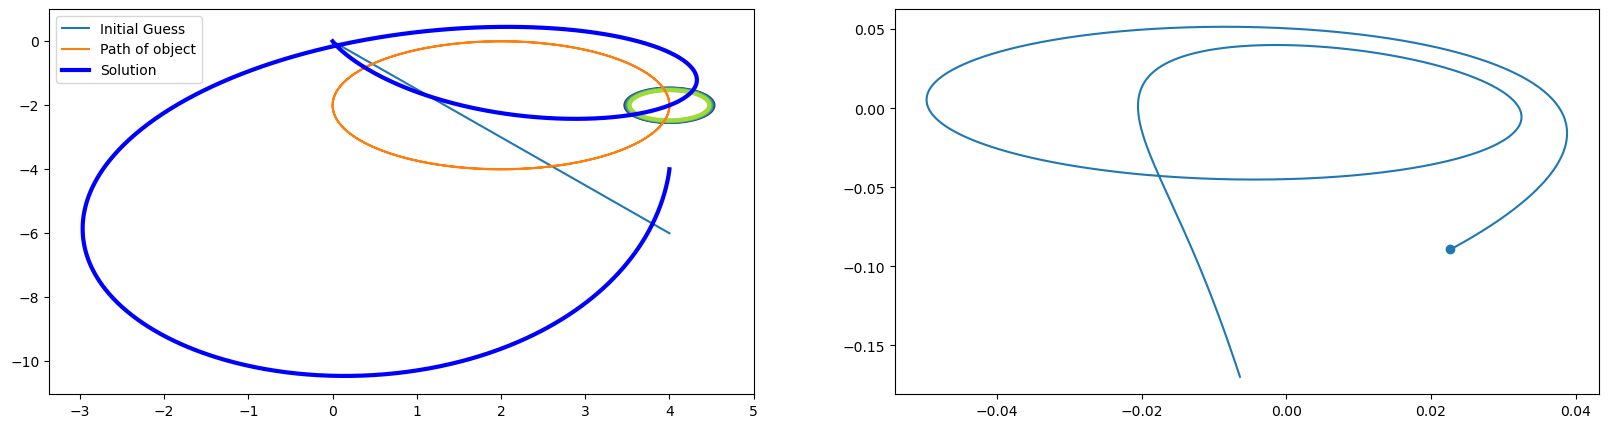

In [20]:
def c_f(t):
    """
    Path of Object we need to avoid
    """
    return (2+2*np.cos(np.pi*t),-2+2*np.sin(np.pi*t))
def func(t, vars):
    """
    Defines what to return as the derivative
    """
    x, y, dx, dy, p1, p2, p3, p4 = vars
    c = c_f(t)
    return np.array([dx,
                        dy,
                        1/(2*W2)*p3-8*(x-c[0])/(((x-c[0])**2 + (y-c[1])**2)**(3/2)),
                        1/(2*W2)*p4-8*(y-c[1])/(((x-c[0])**2 + (y-c[1])**2)**(3/2)),
                        obstacle_dx(x, y, W1=W1, r=r, c=c) - 8*(x-c[0])/(((x-c[0])**2 + (y-c[1])**2)**(3/2)),
                        obstacle_dy(x, y, W1=W1, r=r, c=c) - 8*(y-c[1])/(((x-c[0])**2 + (y-c[1])**2)**(3/2)),
                        -p1,
                        -p2
            ])  
def bc(ya,yb):
    """
    Boundary Conditions
    """
    return np.array([
        ya[0],ya[1],ya[2],ya[3],
        yb[0]-4,yb[1]+4,yb[2],yb[3]
    ])
    
# Define how to weight the obstacles
W1 = 100
# Define how to weight the energy consumption
W2 = .001
# Define the radius and starting location of object
r = (.5,.5)
c = c_f(0)

# Define how many steps we are taking
t_steps=1000

# Plot the location of the object
x  = np.linspace(-1,5,t_steps)
y  = np.linspace(1,-5,t_steps)
X,Y = np.meshgrid(x,y)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.contour(X, Y, obstacle(X, Y, W1, r, c), linewidths=3)

# Define the initial guess for our trajectory
y0 = np.ones((8, t_steps))
t = np.linspace(0, 4, t_steps)
y1 = t
y2 = -1.5*t
y0[0,:] = y1
y0[1,:] = y2
y0[3,:] = -1*np.ones(t_steps)   
plt.plot(y1,y2,label="Initial Guess")

# Solve the system
sol = solve_bvp(func, bc, t, y0, max_nodes=30_000)
plt.plot(c_f(t)[0],c_f(t)[1], label="Path of object")
# Plot the solution
plt.plot(sol.sol(t)[0],sol.sol(t)[1], color="b", linewidth=3, label="Solution")
plt.legend()

# Plot the proportional control
plt.subplot(122)
plt.scatter(sol.sol(t)[6][0],sol.sol(t)[7][0])
plt.plot(sol.sol(t)[6],sol.sol(t)[7])

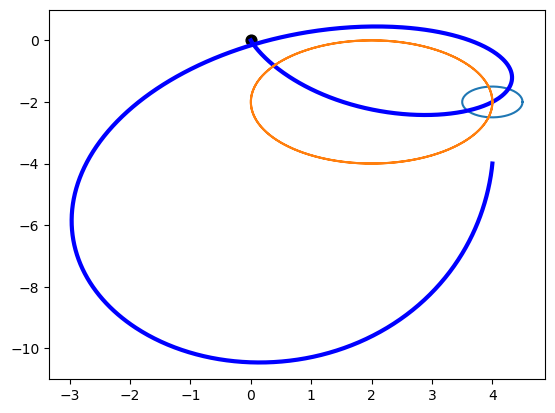

In [21]:
# Make the 
# Define our circle and linspace
theta = np.linspace(0,2*np.pi)
t = np.linspace(0, 4, t_steps)

# Get the figure and plot our objects
fig = plt.figure()
circle, = plt.plot(c_f(0)[0]+r[0]*np.cos(theta),c_f(0)[1]+r[0]*np.sin(theta))
plt.plot(sol.sol(t)[0],sol.sol(t)[1], color="b", linewidth=3, label="Solution")
plt.plot(c_f(t)[0],c_f(t)[1], label="Path of object")
scat = plt.scatter([sol.sol(0)[0]],[sol.sol(0)[1]], s=60, color="k")
# Define update function to update obstacle and ship8
def update(i):
    circle.set_data(c_f(t[i])[0]+r[0]*np.cos(theta),c_f(t[i])[1]+r[0]*np.sin(theta))
    scat.set_offsets([sol.sol(t[i])[0],sol.sol(t[i])[1]])
    return circle
frames = np.arange(len(t))
ani = FuncAnimation(fig, update, frames=frames, interval = 20)
ani.save("single_object_gravity.mp4", writer="ffmpeg", fps=100, bitrate=1800, dpi=100)